In [1]:
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12.5, 4)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

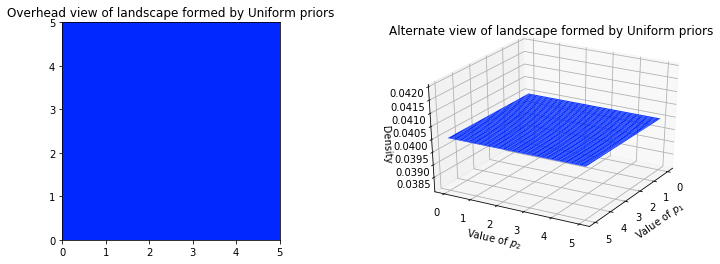

In [2]:
jet = plt.cm.jet
fig = plt.figure()

x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title('Overhead view of landscape formed by Uniform priors')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
ax.set_xlabel('Value of $p_1$')
ax.set_ylabel('Value of $p_2$')
ax.set_zlabel('Density')
plt.title('Alternate view of landscape formed by Uniform priors')

In [3]:
from urllib.request import urlretrieve
urlretrieve('https://git.io/vXt6b', 'data/mixture_dara.csv')

('data/mixture_dara.csv', <http.client.HTTPMessage at 0xa0b52e8>)

[ 115.85679142  152.26153716  178.87449059  162.93500815  107.02820697
  105.19141146  118.38288501  125.3769803   102.88054011  206.71326136] ...


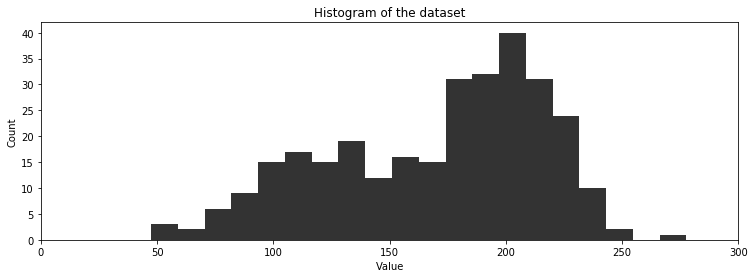

In [5]:
figsize(12.5, 4)
data = np.loadtxt('data/mixture_dara.csv', delimiter=',')
plt.hist(data, bins=20, color='k', histtype='stepfilled', alpha=0.8)
plt.title('Histogram of the dataset')
plt.xlim([0, 300])
plt.ylim([0, None])
plt.xlabel('Value')
plt.ylabel('Count')
print(data[:10], '...')

In [6]:
import pymc3 as pm
import theano.tensor as T

In [9]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0., 1.)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical('assignment', p,
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))

print('prior assignment, with p = {}:'.format(p1.tag.test_value))
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.5:
[0 0 0 1 1 0 1 1 1 1]
